In [103]:
# imports
import copy
from matplotlib import pyplot as plt
%matplotlib inline
import time
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim


In [ ]:
def argmax_tensor(t: torch.Tensor):
	return torch.argmax(t).item()


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
def read_32bit_uint(file):
	return int.from_bytes(file.read(4), "big", signed=False)

def read_byte_uint(file):
	return int.from_bytes(file.read(1), "big", signed=False)

# load MNIST data
def load_mnist(images_filename, labels_filename):
	images = list()
	rows = 0
	cols = 0
	with open(images_filename, 'rb') as file:
		magic_number = read_32bit_uint(file)
		number_images = read_32bit_uint(file)
		rows = read_32bit_uint(file)
		cols = read_32bit_uint(file)
		for image_index in range(number_images):
			image = torch.empty([rows, cols])
			for row_index in range(rows):
				for col_index in range(cols):
					image[row_index, col_index] = 255 - read_byte_uint(file)
			images.append(image)
	
	labels = list()
	label_options = set()
	with open(labels_filename, 'rb') as file:
		magic_number = read_32bit_uint(file)
		number_labels = read_32bit_uint(file)
		for label_index in range(number_labels):
			this_label = read_byte_uint(file)
			labels.append(this_label)
			label_options.add(this_label)
	label_options = list(label_options)
	
	return [(images[i], labels[i]) for i in range(len(images))], (rows, cols), label_options
	
time_load_start = time.time()
mnist_training, training_dimensions, training_label_options = load_mnist("mnist/training/train-images.idx3-ubyte", "mnist/training/train-labels.idx1-ubyte")
mnist_test, test_dimensions, test_label_options = load_mnist("mnist/test/t10k-images.idx3-ubyte", "mnist/test/t10k-labels.idx1-ubyte")
time_load_end = time.time()
print("Loaded MNIST data in", time_load_end - time_load_start, "seconds")

# construct a dictionary from label value to index in training_label_options
label_to_index = dict()
for index, label_value in enumerate(training_label_options):
	label_to_index[label_value] = index


In [162]:
# verify data
if training_dimensions != test_dimensions:
	print("WARNING: training data dimensions and test data dimensions do not match!")
	print("training dimensions:", training_dimensions)
	print("test dimensions:", test_dimensions)
else:
	print("input dimensions:", training_dimensions)
if training_label_options != test_label_options:
	print("WARNING: training data labels and test data labels do not match!")
	print("training labels:", training_label_options)
	print("test labels:", test_label_options)
else:
	print("available labels:", test_label_options)


input dimensions: (28, 28)
available labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [163]:
# define my generic simple net class
class SimpleNet(nn.Module):
	def __init__(self, input_size, hidden_layer_size, output_size):
		super(SimpleNet, self).__init__()
		# save the meta-parameters
		self.input_size = input_size
		self.hidden_layer_size = hidden_layer_size
		self.output_size = output_size
		self.hidden_layers_count = 2
		# figure out if we can use a GPU
		if torch.cuda.is_available():
			self.device = torch.device("cuda")
		else:
			self.device = None
		# create layer transitions
		self.layer_input_to_1 = nn.Parameter(torch.ones([self.hidden_layer_size, self.input_size], requires_grad=True).cuda(), True)
		self.layer_1_to_2 = nn.Parameter(torch.ones([self.hidden_layer_size, self.hidden_layer_size], requires_grad=True).cuda(), True)
		self.layer_2_to_output = nn.Parameter(torch.ones([self.output_size, self.hidden_layer_size], requires_grad=True).cuda(), True)
		# move transition layers to GPU if we can
		# if not self.device is None:
		# 	self.layer_input_to_1 = self.layer_input_to_1.cuda()
		# 	self.layer_1_to_2 = self.layer_1_to_2.cuda()
		# 	self.layer_2_to_output = self.layer_2_to_output.cuda()
 
	def forward(self, x: torch.Tensor):
		if not self.device is None:
			x = x.to(self.device)
		x = f.relu(self.layer_input_to_1.matmul(x))
		x = f.relu(self.layer_1_to_2.matmul(x))
		x = f.relu(self.layer_2_to_output.matmul(x))
		return x
	
	
def forward_grayscale_image(net, image: torch.Tensor):
	x = image.view([-1])
	return net.forward(x)

# function to test accuracy on a dataset
def calculate_accuracy(net, test_data):
	total_count = len(test_data)
	if total_count == 0:
		print("no data to test")
		return 0
	correct = 0
	for input_image, correct_output in test_data:
		correct_label = argmax_tensor(correct_output)
		actual_output = forward_grayscale_image(net, input_image)
		actual_label = training_label_options[argmax_tensor(actual_output)]
		if actual_label == correct_label:
			correct += 1
	return correct / total_count


In [164]:
# construct an instance
linear_input_size = 1
for dimension_size in training_dimensions:
	linear_input_size *= dimension_size
net_MNIST = SimpleNet(linear_input_size, 30, len(training_label_options))
# TODO
# net_MNIST = nn.Sequential(torch.nn.Linear(linear_input_size, 30),
#     torch.nn.ReLU(),
#     torch.nn.Linear(30, len(training_label_options)))
print(net_MNIST)
params = list(net_MNIST.parameters())
print(len(params))


SimpleNet()
3


# of training data: 60000
# of testing data: 10000


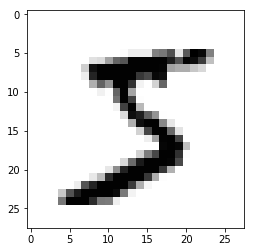

In [165]:
# show one of the images to test if we've loaded MNIST data
test_image, test_label = mnist_training[0]
# convert the image to floats
test_image = test_image.float()
plt.imshow(test_image, cmap="gray", vmin=0, vmax=255)
# show how many data we have
print("# of training data:", len(mnist_training))
print("# of testing data:", len(mnist_test))


In [166]:
# re-shape the images into vectors

def label_to_vector(label: int):
	target_vector = torch.zeros([len(training_label_options)])
	target_vector[label_to_index[label]] = 1.0
	return target_vector

mnist_training_vectors = [(image.view([-1]), label_to_vector(label)) for image, label in mnist_training]
mnist_test_vectors = [(image.view([-1]), label_to_vector(label)) for image, label in mnist_test]


In [178]:
# train the net

# def label_to_vector_batch(label_batch):
# 	return torch.stack([label_to_vector(label) for label in label_batch])
# 
# def create_batches(training_data, minimum_batch_size):
# 	data_count = len(training_data)
# 	number_of_batches = data_count // minimum_batch_size
# 	batches = [list() for i in range(number_of_batches)]
# 	unused_datum_indices = set(range(data_count))
# 	batch_index = 0
# 	while len(unused_datum_indices) > 0:
# 		chosen_index = unused_datum_indices.pop()
# 		batches[batch_index].append(training_data[chosen_index])
# 		batch_index += 1
# 		batch_index %= number_of_batches
# 	return batches

class SimpleCustomBatch:
    def __init__(self, data):
        transposed_data = list(zip(*data))
        self.input = torch.stack(transposed_data[0], 0)
        self.target = torch.stack(transposed_data[1], 0)

    def pin_memory(self):
        self.input = self.input.pin_memory()
        self.target = self.target.pin_memory()
        return self

def collate_wrapper(batch_data):
    return SimpleCustomBatch(batch_data)

def train(net, full_training_data, learning_rate, batch_size):
	# split training data into training and verification
	split_index = int(len(full_training_data) * 0.9)
	training_data = full_training_data[:split_index]
	verification_data = full_training_data[split_index:]
	# make a place to record accuracy
	domain = list()
	accuracy_values = list()
	# build some random things we need...
	time_training_start = time.time()
	optimizer = optim.Adam(net.parameters(), lr=learning_rate)
	loss_function = nn.MSELoss(reduction="sum")
	inputs_tensor = torch.stack([datum[0] for datum in training_data], dim=0)
	outputs_tensor = torch.stack([datum[1] for datum in training_data], dim=0)
	print("inputs_tensor dimensions:", inputs_tensor.size())
	print("outputs_tensor dimensions:", outputs_tensor.size())
	dataset = TensorDataset(inputs_tensor, outputs_tensor)
	loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_wrapper, pin_memory=True)
	# ensures the next loop runs at least once
	verification_accuracy_previous = -1.0
	verification_accuracy_current = calculate_accuracy(net, verification_data)
	# save accuracy
	domain.append(time.time() - time_training_start)
	accuracy_values.append(verification_accuracy_current)
	# train until the verification accuracy goes down by more than a specified margin
	while verification_accuracy_current - verification_accuracy_previous > -0.005:
		first_batch = True
		for batch in loader:
			batch_tensor_input = batch.input.transpose(0, 1)
			batch_tensor_target = batch.target.transpose(0, 1)
			if not net.device is None:
				batch_tensor_target = batch_tensor_target.to(net.device)
			optimizer.zero_grad()
			output = net(batch_tensor_input)
			loss = loss_function(output, batch_tensor_target)
			# if first_batch:
			# 	first_batch = False
			# 	print(loss.item())
			loss.backward()
			params_before = copy.copy(list(net.parameters()))
			optimizer.step()
			params_after = copy.copy(list(net.parameters()))
			if first_batch:
				first_batch = False
				max_diff = -1.0
				for i in range(len(params_after)):
					difference = abs(params_after[i] - params_before[i])
					this_max_diff = max([max([difference[row, col].item() for row in range(difference.shape[0])]) for col in range(difference.shape[1])])
					if this_max_diff > max_diff:
						max_diff = this_max_diff
				print("max_diff:", max_diff)
		verification_accuracy_previous = verification_accuracy_current
		verification_accuracy_current = calculate_accuracy(net, verification_data)
		# save accuracy
		domain.append(time.time() - time_training_start)
		accuracy_values.append(verification_accuracy_current)
		print("verification_accuracy_current:", verification_accuracy_current)
	# plot the accuracy over time
	plt.plot(domain, accuracy_values)
	plt.xlabel("time elapsed (s)")
	plt.ylabel("accuracy")
	plt.show()

LEARNING_RATE = 0.1
train(net_MNIST, mnist_training_vectors, LEARNING_RATE, 200)


inputs_tensor dimensions: torch.Size([54000, 784])
outputs_tensor dimensions: torch.Size([54000, 10])
max_diff: 0.0
verification_accuracy_current: 0.11133333333333334
max_diff: 0.0
verification_accuracy_current: 0.11133333333333334
max_diff: 0.0
verification_accuracy_current: 0.11133333333333334
max_diff: 0.0
verification_accuracy_current: 0.11133333333333334
max_diff: 0.0
verification_accuracy_current: 0.11133333333333334
max_diff: 0.0


KeyboardInterrupt: 

In [ ]:
# run some tests
final_accuracy = calculate_accuracy(net_MNIST, mnist_test_vectors)
print("final accuracy:", final_accuracy)

